In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

In [2]:
class ShockTubeSPH:
    """
    一个用于模拟一维SOD激波管问题的SPH求解器。
    """
    def __init__(self, N=400, NT=400, dt=0.001):
        # 模拟参数
        self.dim = 1
        self.N = N      # 粒子数量
        self.NT = NT    # 时间步数
        self.dt = dt    # 时间步长
        self.gamma = 1.4

        # 存储历史数据
        self.Ytime1 = np.zeros((6, self.N, self.NT))
        self.Ptime = np.zeros((1, self.N, self.NT))
        self.t = np.zeros(self.NT + 1)

        # 初始化状态向量 Y
        self.Y = self._initialize_conditions()

    def _initialize_conditions(self):
        mass = 0.001875 * np.ones((1, self.N))
        v0 = np.zeros((self.dim, self.N))
        
        E0 = np.zeros((1, self.N))
        X0 = np.zeros((self.dim, self.N))
        rho0 = np.zeros((1, self.N))
        
        n_left = self.N - 80
        n_right = 80
        
        E0[:, :n_left] = 2.5
        E0[:, n_left:] = 1.795
        
        X0[:, :n_left] = np.linspace(-0.6, -0.001875, n_left)
        X0[:, n_left:] = np.linspace(0.0075, 0.6, n_right)

        rho0[:, :n_left] = 1.0
        rho0[:, n_left:] = 0.25

        H = 0.01 * np.ones((1, self.N))
        
        Y = np.vstack([v0, E0, X0, rho0, H, mass])
        return Y

    def Kernel(self, dx, h):
        alpha_1 = [1/h, 15/(7*math.pi*h**2), 3/(2*math.pi*h**3)]
        r = np.linalg.norm(dx)
        R = r / h if h > 0 else float('inf')
        W = 0.0
        dWdx = np.zeros(self.dim)
        alpha_d = alpha_1[self.dim - 1]

        if 0 <= R < 1:
            W = alpha_d * (2/3 - R**2 + 1/2 * R**3)
            if h > 1e-12:
                dWdx = alpha_d * (-2 + 3/2 * R) * (dx / h**2)
        elif 1 <= R < 2:
            W = alpha_d * 1/6 * (2 - R)**3
            if h > 1e-12 and r > 1e-12:
                dWdx = -alpha_d * 1/2 * (2 - R)**2 * (dx / (h * r))
        
        return W, dWdx

    def NN_pairs(self, Y, N): 
        X = Y[self.dim+1 : 2*self.dim+1, :]
        H = Y[-2, :]
        kappa = 2.0
        
        pair_i, pair_j = [], []
        W_array, dWdx_array = [], []

        for i in range(N):
            for j in range(i + 1, N):
                h = (H[i] + H[j]) / 2
                dx = X[:, i] - X[:, j]
                
                if np.linalg.norm(dx) <= kappa * h:
                    pair_i.append(i)
                    pair_j.append(j)
                    W, dWdx = self.Kernel(dx, h)
                    W_array.append(W)
                    dWdx_array.append(dWdx)
        
        return np.array(W_array), np.array(dWdx_array).T, len(pair_i), np.array(pair_i), np.array(pair_j)

    def density(self, Y, W_array, N, niac, pair_j, pair_i): 
        H = Y[-2, :]
        mass = Y[-1, :]
        rho = np.zeros(N)

        for i in range(N):
            W0, _ = self.Kernel(np.zeros(self.dim), H[i])
            rho[i] = mass[i] * W0

        for k in range(niac):
            i, j = pair_i[k], pair_j[k]
            rho[i] += mass[j] * W_array[k]
            rho[j] += mass[i] * W_array[k]
            
        return rho

    def pressure(self, Y):
        E = Y[self.dim, :]
        rho = Y[-3, :]
        P = (self.gamma - 1) * rho * E
        return P

    def visco(self, i, j, Y):
        v = Y[0:self.dim, :]
        E = Y[self.dim, :]
        X = Y[self.dim+1 : 2*self.dim+1, :]
        rho = Y[-3, :]
        H = Y[-2, :]

        cij = 0.5 * math.sqrt(self.gamma - 1) * (math.sqrt(E[i]) + math.sqrt(E[j]))
        rhoij = 0.5 * (rho[i] + rho[j])
        h = 0.5 * (H[i] + H[j])
        vij = v[:, i] - v[:, j]
        Xij = X[:, i] - X[:, j]
        
        phiij = (h * np.dot(vij, Xij)) / (np.linalg.norm(Xij)**2 + (0.1 * h)**2 + 1e-9)
        
        return (-cij * phiij + phiij**2) / rhoij if np.dot(vij, Xij) < 0 else 0.0
            
    def forces(self, Y, N): 
        v = Y[0:self.dim, :]
        mass = Y[-1, :]
        
        W_array, dWdx_array, niac, pair_i, pair_j = self.NN_pairs(Y, N)
        
        rho = self.density(Y, W_array, N, niac, pair_j, pair_i)
        Y[-3, :] = rho

        P = self.pressure(Y)
        
        dvdt = np.zeros_like(v)
        dedt = np.zeros(N)
        
        for k in range(niac):
            i, j = pair_i[k], pair_j[k]
            vscty = self.visco(i, j, Y)
            A = (P[i] / (rho[i]**2) + P[j] / (rho[j]**2) + vscty)
            dWdx = dWdx_array[:, k]
            
            dvdt[:, i] -= mass[j] * A * dWdx
            dvdt[:, j] += mass[i] * A * dWdx
            
            vij_dot_dWdx = np.dot(v[:, i] - v[:, j], dWdx)
            dedt[i] += 0.5 * mass[j] * A * vij_dot_dWdx
            dedt[j] += 0.5 * mass[i] * A * vij_dot_dWdx
        
        dxdt = v
        drhodt = np.zeros(N); dHdt = np.zeros(N); dmdt = np.zeros(N)
        
        g = np.vstack([dvdt, dedt, dxdt, drhodt, dHdt, dmdt])
        return g, rho, P

    def runge_kutta(self, Y, N, dt): 
        
        _, rho, _ = self.forces(Y, N)
        
        a, _, _ = self.forces(Y, N)
        b, _, _ = self.forces(Y + a * dt / 2, N)
        c, _, _ = self.forces(Y + b * dt / 2, N)
        d, _, _ = self.forces(Y + c * dt, N)
        
        Yn = Y + (1/6)*dt*a + (1/3)*dt*b + (1/3)*dt*c + (1/6)*dt*d
        
        Yn[-3, :] = rho #使用RK开始时计算的rho来更新最终状态
        
        P_final = self.pressure(Yn)
        
        
        # 根据更新后的位置 Yn 重新计算密度
        #[_, rho_new, P_new] = self.forces(Yn, N);
    
        # 用【新】的密度和压力更新最终状态
        #Yn[-3,:] = rho_new;
        #P_final = P_new;
        
        return Yn, P_final

    def run_simulation(self):
        for n in range(self.NT):
            print(f"Step {n+1}/{self.NT}", end="\r")
            
            self.Y, P = self.runge_kutta(self.Y, self.N, self.dt)
            
            self.t[n+1] = self.t[n] + self.dt
            self.Ytime1[:, :, n] = self.Y
            self.Ptime[:, :, n] = P
        print("\nSimulation Finished.")

    def create_animation(self):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('SPH Shock Tube Simulation', fontsize=16)

        line1, = axes[0, 0].plot([], [], '.r', markersize=5)
        line2, = axes[0, 1].plot([], [], '.g', markersize=5)
        line3, = axes[1, 0].plot([], [], '.b', markersize=5)
        line4, = axes[1, 1].plot([], [], '.k', markersize=5)
        
        lines = [line1, line2, line3, line4]
        
        x_pos_idx = self.dim + 1
        axes[0, 0].set_xlim(-0.4, 0.4); axes[0, 0].set_ylim(0, 1.8); axes[0, 0].set_title('Velocity'); axes[0, 0].set_xlabel('x (m)'); axes[0, 0].set_ylabel('Velocity (m/s)'); axes[0,0].grid(True)
        axes[0, 1].set_xlim(-0.4, 0.4); axes[0, 1].set_ylim(1.6, 2.8); axes[0, 1].set_title('Internal Energy'); axes[0, 1].set_xlabel('x (m)'); axes[0, 1].set_ylabel('Internal Energy (J/Kg)'); axes[0,1].grid(True)
        axes[1, 0].set_xlim(-0.4, 0.4); axes[1, 0].set_ylim(0, 1.2); axes[1, 0].set_title('Density'); axes[1, 0].set_xlabel('x (m)'); axes[1, 0].set_ylabel('Density (Kg/m^3)'); axes[1,0].grid(True)
        axes[1, 1].set_xlim(-0.4, 0.4); axes[1, 1].set_ylim(0, 1.2); axes[1, 1].set_title('Pressure'); axes[1, 1].set_xlabel('x (m)'); axes[1, 1].set_ylabel('Pressure (N/m^2)'); axes[1,1].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        def update(frame):
            x_data = self.Ytime1[x_pos_idx, :, frame]
            
            y_data_vel = self.Ytime1[0, :, frame]
            y_data_energy = self.Ytime1[1, :, frame]
            y_data_density = self.Ytime1[3, :, frame]
            y_data_pressure = self.Ptime[0, :, frame]
            
            lines[0].set_data(x_data, y_data_vel)
            lines[1].set_data(x_data, y_data_energy)
            lines[2].set_data(x_data, y_data_density)
            lines[3].set_data(x_data, y_data_pressure)
            return lines

        ani = animation.FuncAnimation(fig, update, frames=self.NT, blit=True, interval=50)
        
        print("Saving animation to shockwave.gif...")
        ani.save('shockwave.gif', writer='pillow', fps=15) 
        print("Animation saved.")

Step 400/400
Simulation Finished.
Saving animation to shockwave.gif...
Animation saved.


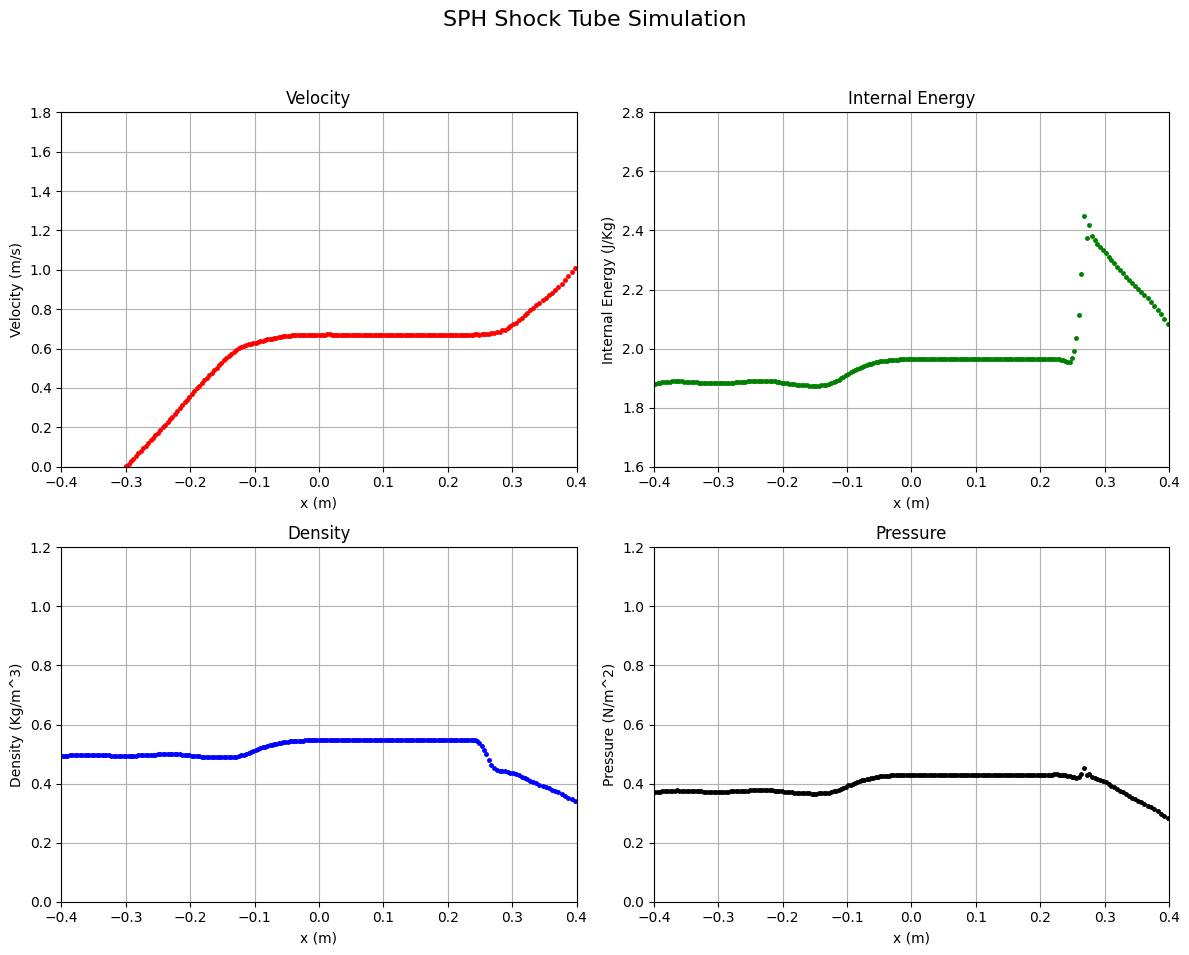

In [3]:
if __name__ == '__main__':
    simulation = ShockTubeSPH()
    simulation.run_simulation()
    simulation.create_animation()

Animation saved as 'shockwave.gif'. Now displaying in notebook...


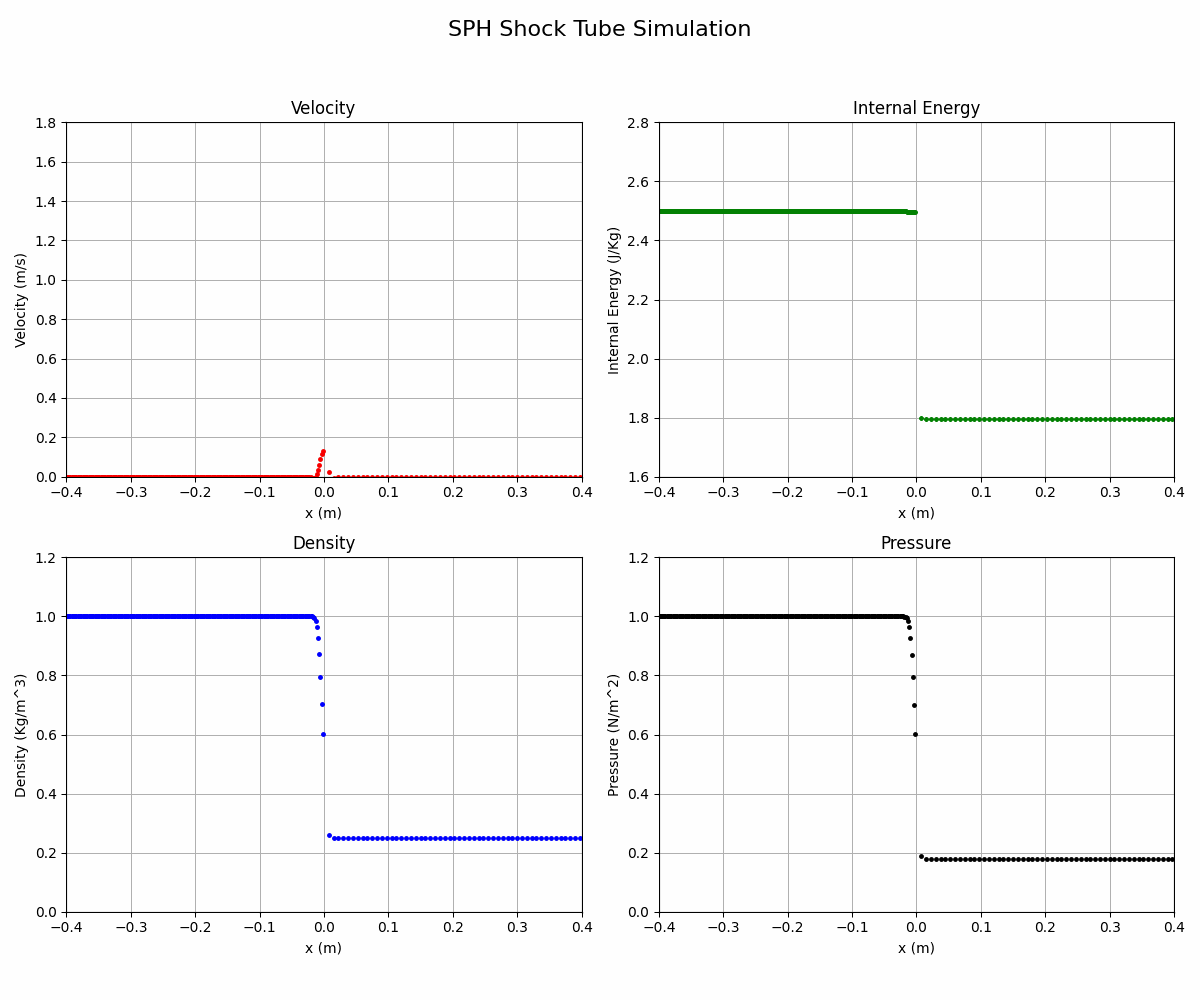

In [7]:
from IPython.display import display, Image

print(f"Animation saved as '{'shockwave.gif'}'. Now displaying in notebook...")
display(Image(filename='shockwave.gif'))